In [3]:
# Nothing better to begin with than by importing some necessary dependencies. 
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import random
import sys
import my_utils as mu
d2l = sys.modules[__name__]

In [4]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a)

In [5]:
import pickle
path_to_the_pickle = './test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))
# 6 test functions
i = 1 # i=1,..6
name= 'function_num_{}'.format(i)
x_c=test_data[name]['context_pairs'][0]
y_c=test_data[name]['context_pairs'][1]
x_t =test_data[name]['x']

In [6]:
n_c = random.randint(3, 35)
print(n_c)
dataset = data.TensorDataset(x[:n_c], y[:n_c])
batch_size = 16
data_iter =  data.DataLoader(dataset, batch_size, shuffle=True)

20


In [7]:
class Encoder(torch.nn.Module):
    def __init__(self, num_inputs):
        super(Encoder, self).__init__()
        self.num_inputs = num_inputs
    def forward(self, x):
        encounter = 0
        xr_c = []
        yr_c = []
        for value in x[0]:
            averagex = torch.mean(x[0][encounter])
            averagey = torch.mean(x[1][encounter])
            xr_c.append(averagex)
            yr_c.append(averagey)
            encounter += 1
        avgxr_c = sum(xr_c)/len(xr_c)
        avgyr_c = sum(yr_c)/len(yr_c)
        r_c = [avgxr_c, avgyr_c]
        return r_c

In [8]:
class Decoder(torch.nn.Module):
    def __init__(self, num_inputs):
        super(Decoder, self).__init__()
        self.num_inputs = num_inputs
        self.Linear1 = torch.nn.Linear(3,1)
        self.Sigmoid = torch.nn.Sigmoid()
        self.Linear2 = torch.nn.Linear(1,40,1)
        
    def forward(self, x):
        r_c = x[0]
        x_c = x[1][0]
        i = 0
        for a in x[1]:
            i += 1
            for b in x[1][0]:
                a = torch.tensor([r_c[0], r_c[1], b])
                y_hat = self.Linear1(a)
                y_hat = self.Sigmoid(y_hat)
                y_hat = self.Linear2(y_hat)
                y_hat = y_hat.view(1, 40, 1)
        return y_hat

In [9]:
# Create and initialize model:
num_inputs = Npts
# Needs to produce context feature: a sum of all features x and y
net = Encoder(num_inputs)
decoder = Decoder(num_inputs)

In [10]:
def train(net, train_iter, loss, optimizer, epochs):
    i = 0
    x = 0
    for epoch in range(epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            r_c = net([X, y])
            y_hat = decoder([r_c, X])
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            x += 1
    return y_hat

In [11]:
loss = torch.nn.MSELoss()
lr = 0.1
optimizer = torch.optim.SGD(decoder.parameters(), lr)
y_hat = train(net, data_iter, loss, optimizer, 1000)

/Users/johnsn27/Documents/Uni/artificialIntelligence/ai/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([16, 40, 1])) that is different to the input size (torch.Size([1, 40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/johnsn27/Documents/Uni/artificialIntelligence/ai/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([4, 40, 1])) that is different to the input size (torch.Size([1, 40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


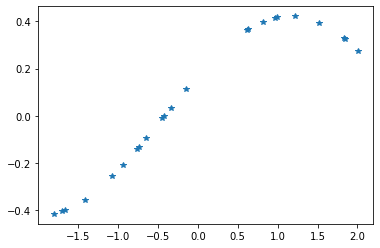

In [12]:
plt.plot(x_c[0,:,0].to('cpu'), y_c[0,:,0].to('cpu'), '*')

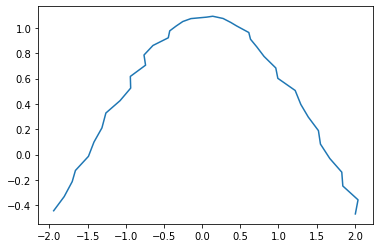

In [13]:
plt.plot(x_t[0,:,0].to('cpu'), y_hat[0,:,0].detach().to('cpu'))

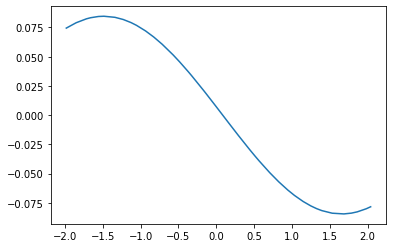

In [14]:
plt.plot(x[0,:,0].to('cpu'), y[0,:,0].to('cpu'))

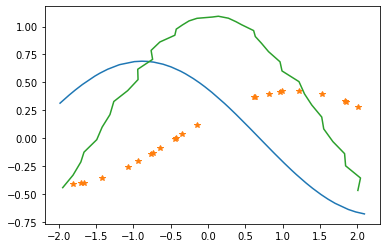

In [15]:
plt.plot(x[3,:,0].to('cpu'), y[3,:,0].to('cpu'))
plt.plot(x_c[0,:,0].to('cpu'), y_c[0,:,0].to('cpu'), '*')
plt.plot(x_t[0,:].to('cpu'), y_hat[0,:].detach().to('cpu'))